In [1]:
import numpy as np 
import pandas as pd 

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras import regularizers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('/content/fer2013.csv')

In [6]:
data.shape

(35887, 3)

In [7]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['pixels'], data['emotion'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Create new DataFrames for training, validation, and test sets
train_df = pd.DataFrame({'emotions': y_train, 'pixel': X_train, 'label': 'training'})
val_df = pd.DataFrame({'emotions': y_val, 'pixel': X_val, 'label': 'validation'})
test_df = pd.DataFrame({'emotions': y_test, 'pixel': X_test, 'label': 'test'})

# Concatenate the DataFrames
new_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [ ]:
new_df.label.value_counts()

training      22967
test           7178
validation     5742
Name: label, dtype: int64

In [ ]:
emotion_desc = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_num = data['emotion'].value_counts(sort=False).reset_index()
emotion_num.columns = ['emotion', 'number']
emotion_num['emotion'] = emotion_num['emotion'].map(emotion_desc)

In [ ]:
emotion_num

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


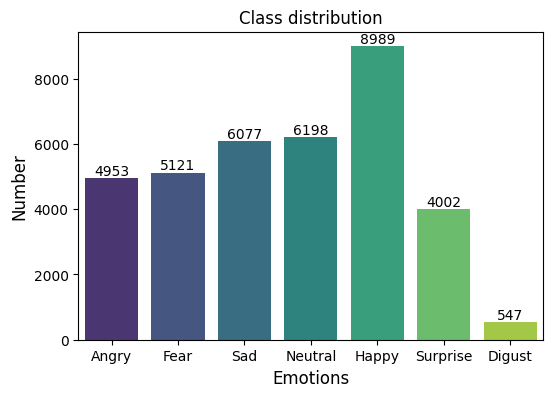

In [ ]:
#Plotting a bar graph of the class distributions
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=emotion_num.emotion, y=emotion_num.number, palette='viridis')

# Adding numbers on each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=10)

plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

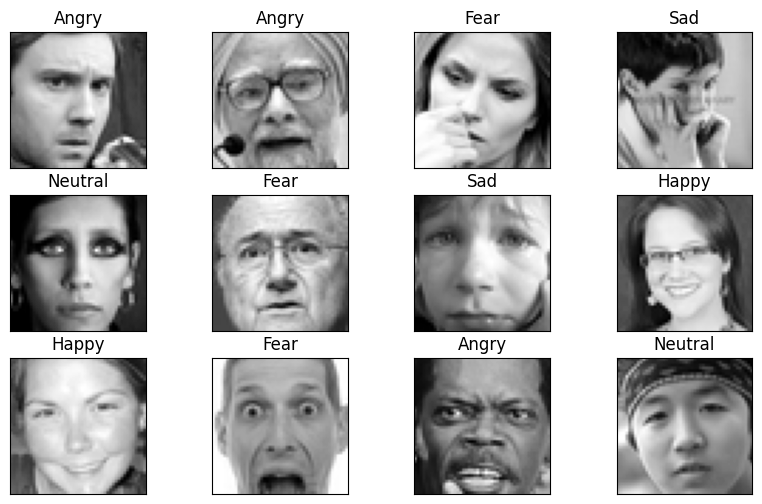

In [ ]:
X = []
y = []
CATEGORIES = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

for index, row in data.iterrows():
    try:
        pixels=np.asarray(list(row['pixels'].split(' ')), dtype=np.uint8)
        img = pixels.reshape((48,48))
        X.append(img)
        y.append(row['emotion'])
    except Exception as e:
        pass


fig=plt.figure(figsize=(10,6))

for counter, img in enumerate(X[:12]):
    ax = fig.add_subplot(3,4,counter+1)
    ax.imshow(X[counter], cmap='gray')
    plt.title(CATEGORIES[y[counter]])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
df_train = new_df[new_df['label']=='training'].copy()
df_val   = new_df[new_df['label']=='validation'].copy()
df_test  = new_df[new_df['label']=='test'].copy()

In [ ]:
df_train

,emotions,pixel,label
0,5,153 87 59 44 43 43 41 40 40 40 41 41 39 37 37 ...,training
1,4,39 22 22 28 27 27 26 26 27 30 35 37 41 46 47 5...,training
2,6,166 165 172 169 118 64 67 73 81 84 91 98 98 95...,training
3,5,27 25 38 17 37 41 37 34 37 75 93 84 84 89 99 1...,training
4,6,62 46 31 39 49 36 32 39 44 55 77 95 102 108 11...,training
...,...,...,...
22962,3,72 67 74 70 66 55 27 11 8 7 7 9 10 10 14 17 16...,training
22963,0,49 46 45 46 46 42 33 32 31 30 37 37 47 68 89 8...,training
22964,3,186 198 164 138 171 163 143 143 134 164 203 19...,training
22965,0,39 36 34 34 32 28 27 27 26 27 26 26 25 26 29 2...,training


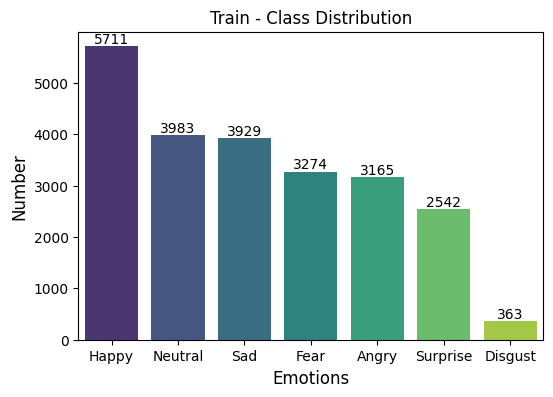

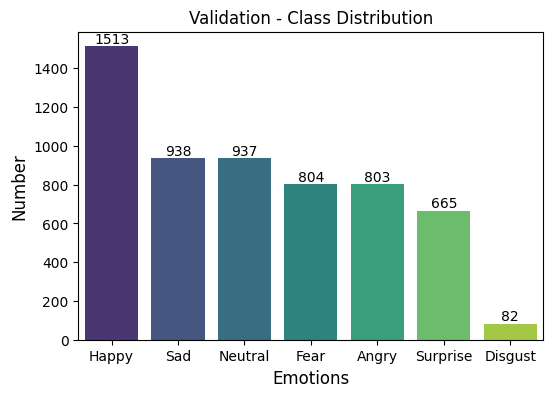

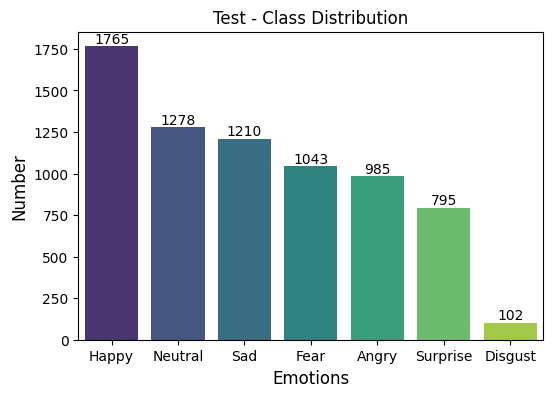

In [ ]:
def plot_class_distribution(data, title):
    # Define emotion labels
    emotion_desc = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    # Calculate class distributions
    emotion_num = data['emotions'].value_counts().reset_index()
    emotion_num.columns = ['emotion', 'number']

    # Replace emotion labels with descriptions
    emotion_num['emotion'] = emotion_num['emotion'].map(emotion_desc)

    # Plotting a bar graph of the class distributions
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=emotion_num.emotion, y=emotion_num.number, palette='viridis')

    # Adding numbers on each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

    plt.title(title)
    plt.ylabel('Number', fontsize=12)
    plt.xlabel('Emotions', fontsize=12)
    plt.show()


plot_class_distribution(df_train, 'Train - Class Distribution')
plot_class_distribution(df_val, 'Validation - Class Distribution')
plot_class_distribution(df_test, 'Test - Class Distribution')

# Downsampling

In [8]:
from sklearn.utils import resample
# Determine the minimum class count
class_count = data['emotion'].value_counts()
min_class_count = class_count.min()

# Downsampling the majority class
downsampled_data = []
for class_label in class_count.index:
    class_samples = data[data['emotion'] == class_label]
    downsampled_samples = resample(
        class_samples,
        replace=False,
        n_samples=min_class_count,
        random_state=42
    )
    downsampled_data.append(downsampled_samples)

# Create downsampled DataFrame
df_downsampled = pd.concat(downsampled_data)

# Split the downsampled DataFrame back into X and y
X_downsampled = df_downsampled['pixels']
y_downsampled = df_downsampled['emotion']

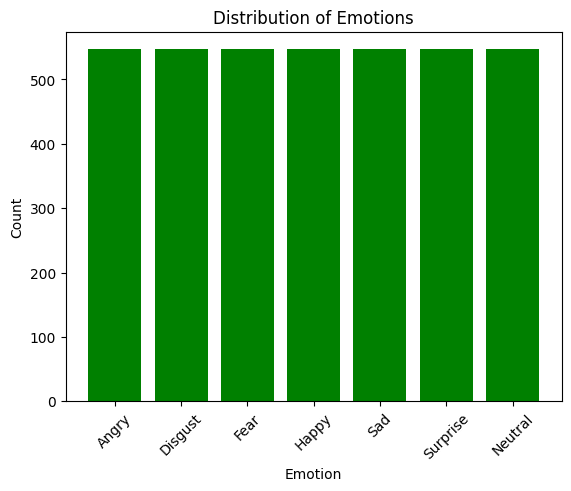

In [9]:
import matplotlib.pyplot as plt

# Count the occurrences of each emotion
emotion_counts = y_downsampled.value_counts()

# Map emotion labels to the corresponding integers
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Create a bar plot
plt.bar(emotion_labels.values(), emotion_counts, color = 'green')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(2450,)
(2450,)
(613,)
(613,)
(766,)
(766,)


In [12]:
X_train

7063     79 70 40 57 32 33 36 30 33 18 21 41 57 51 43 3...
18804    0 0 0 1 0 29 233 251 246 249 247 245 249 248 2...
3434     26 19 25 37 33 20 16 22 25 19 31 27 36 65 61 7...
7503     13 4 5 2 2 4 5 5 3 3 4 12 19 31 49 66 77 82 86...
9008     205 205 203 203 205 213 214 212 152 123 168 18...
                               ...                        
7439     16 17 20 18 22 28 24 31 51 59 77 85 84 97 105 ...
32498    160 138 104 81 63 68 67 66 58 55 43 34 48 84 1...
21189    255 255 249 201 166 147 127 125 170 136 94 79 ...
14809    180 178 106 17 33 39 56 64 66 78 84 88 90 97 9...
25856    197 188 191 193 185 190 187 181 172 170 170 17...
Name: pixels, Length: 2450, dtype: object

# Data Preprocessing for CNN

In [13]:
# convert pixels which are in form of strings to lists of integers
X_train = X_train.apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
X_val = X_val.apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
X_test = X_test.apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])

In [14]:
X_train

7063     [79, 70, 40, 57, 32, 33, 36, 30, 33, 18, 21, 4...
18804    [0, 0, 0, 1, 0, 29, 233, 251, 246, 249, 247, 2...
3434     [26, 19, 25, 37, 33, 20, 16, 22, 25, 19, 31, 2...
7503     [13, 4, 5, 2, 2, 4, 5, 5, 3, 3, 4, 12, 19, 31,...
9008     [205, 205, 203, 203, 205, 213, 214, 212, 152, ...
                               ...                        
7439     [16, 17, 20, 18, 22, 28, 24, 31, 51, 59, 77, 8...
32498    [160, 138, 104, 81, 63, 68, 67, 66, 58, 55, 43...
21189    [255, 255, 249, 201, 166, 147, 127, 125, 170, ...
14809    [180, 178, 106, 17, 33, 39, 56, 64, 66, 78, 84...
25856    [197, 188, 191, 193, 185, 190, 187, 181, 172, ...
Name: pixels, Length: 2450, dtype: object

In [15]:
# reshaping to ensure the inputs have the desired shape that matches the input requirements of the CNN model
# normalising helps in improving the convergence and performance of the CNN model during training.
width, height = 48, 48
train_X = np.array(X_train.tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
val_X = np.array(X_val.tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
test_X = np.array(X_test.tolist(), dtype='float32').reshape(-1,width, height,1)/255.0

In [16]:
# converting the categorical labels in the 'emotion' column into one-hot encoded vectors.
train_y = to_categorical(y_train, 7)  
val_y = to_categorical(y_val, 7)
test_y = to_categorical(y_test, 7)

In [17]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(2450, 48, 48, 1)
(2450, 7)
(613, 48, 48, 1)
(613, 7)
(766, 48, 48, 1)
(766, 7)


# Model Development

In [18]:
num_classes = 7

In [ ]:
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model1.add(Flatten())
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 flatten (Flatten)           (None, 67712)             0         
                                                                 
 dense (Dense)               (None, 7)                 473991    
                                                                 
Total params: 474,311
Trainable params: 474,311
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
data_generator = ImageDataGenerator(
                        shear_range = 0.2,
                        rotation_range=10,
                        width_shift_range=0.25,
                        height_shift_range=0.25,
                        zoom_range=0.25,
                        horizontal_flip=True)

In [ ]:
batch_size = 32
num_epochs = 10
history = model1.fit_generator(data_generator.flow(train_X, train_y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                validation_data=(val_X, val_y))

Epoch 1/10


<ipython-input-90-a32b18513447>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(data_generator.flow(train_X, train_y, batch_size),


76/76 - 2s - loss: 1.7910 - accuracy: 0.2955 - val_loss: 1.8436 - val_accuracy: 0.2610 - 2s/epoch - 29ms/step
Epoch 2/10
76/76 - 2s - loss: 1.7826 - accuracy: 0.3086 - val_loss: 1.8648 - val_accuracy: 0.2969 - 2s/epoch - 30ms/step
Epoch 3/10
76/76 - 3s - loss: 1.7778 - accuracy: 0.3073 - val_loss: 1.8975 - val_accuracy: 0.2512 - 3s/epoch - 39ms/step
Epoch 4/10
76/76 - 2s - loss: 1.7838 - accuracy: 0.3094 - val_loss: 1.8426 - val_accuracy: 0.2838 - 2s/epoch - 29ms/step
Epoch 5/10
76/76 - 2s - loss: 1.7737 - accuracy: 0.3122 - val_loss: 1.8503 - val_accuracy: 0.2692 - 2s/epoch - 28ms/step
Epoch 6/10
76/76 - 2s - loss: 1.7795 - accuracy: 0.3139 - val_loss: 1.8593 - val_accuracy: 0.2675 - 2s/epoch - 29ms/step
Epoch 7/10
76/76 - 3s - loss: 1.7523 - accuracy: 0.3302 - val_loss: 1.8354 - val_accuracy: 0.2610 - 3s/epoch - 34ms/step
Epoch 8/10
76/76 - 2s - loss: 1.7598 - accuracy: 0.3143 - val_loss: 1.8338 - val_accuracy: 0.2741 - 2s/epoch - 28ms/step
Epoch 9/10
76/76 - 2s - loss: 1.7466 - accu

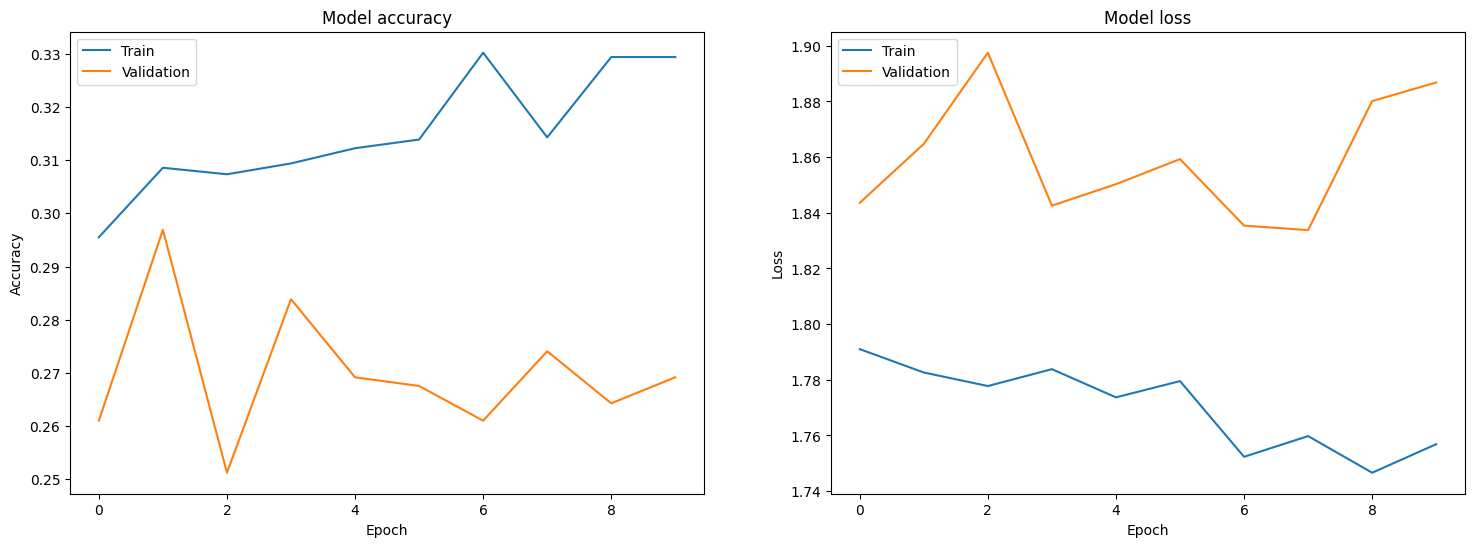

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Increase the number of epochs and adding early stop
By providing more training iterations, the model has more opportunities to fine-tune its parameters and improve its ability to capture patterns in the data.
we use early stop to prevent overfitting and improve generalization performance.

In [ ]:
batch_size = 32
num_epochs = 50

es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

In [ ]:
history = model1.fit_generator(data_generator.flow(train_X, train_y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es],
                                validation_data=(val_X, val_y))

Epoch 1/50


<ipython-input-92-02a75891d5a8>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(data_generator.flow(train_X, train_y, batch_size),


76/76 - 2s - loss: 1.7599 - accuracy: 0.3282 - val_loss: 1.8625 - val_accuracy: 0.2790 - 2s/epoch - 31ms/step
Epoch 2/50
76/76 - 3s - loss: 1.7276 - accuracy: 0.3359 - val_loss: 1.8949 - val_accuracy: 0.2773 - 3s/epoch - 40ms/step
Epoch 3/50
76/76 - 2s - loss: 1.7415 - accuracy: 0.3310 - val_loss: 1.8526 - val_accuracy: 0.2741 - 2s/epoch - 30ms/step
Epoch 4/50
76/76 - 2s - loss: 1.7439 - accuracy: 0.3241 - val_loss: 1.8598 - val_accuracy: 0.2643 - 2s/epoch - 27ms/step
Epoch 5/50
76/76 - 4s - loss: 1.7345 - accuracy: 0.3327 - val_loss: 1.8805 - val_accuracy: 0.2773 - 4s/epoch - 50ms/step
Epoch 6/50
76/76 - 2s - loss: 1.7288 - accuracy: 0.3445 - val_loss: 1.8567 - val_accuracy: 0.2577 - 2s/epoch - 26ms/step
Epoch 7/50
76/76 - 2s - loss: 1.7335 - accuracy: 0.3494 - val_loss: 1.8673 - val_accuracy: 0.2659 - 2s/epoch - 29ms/step
Epoch 8/50
76/76 - 2s - loss: 1.7186 - accuracy: 0.3424 - val_loss: 1.9140 - val_accuracy: 0.2741 - 2s/epoch - 28ms/step
Epoch 9/50
76/76 - 2s - loss: 1.7140 - accu

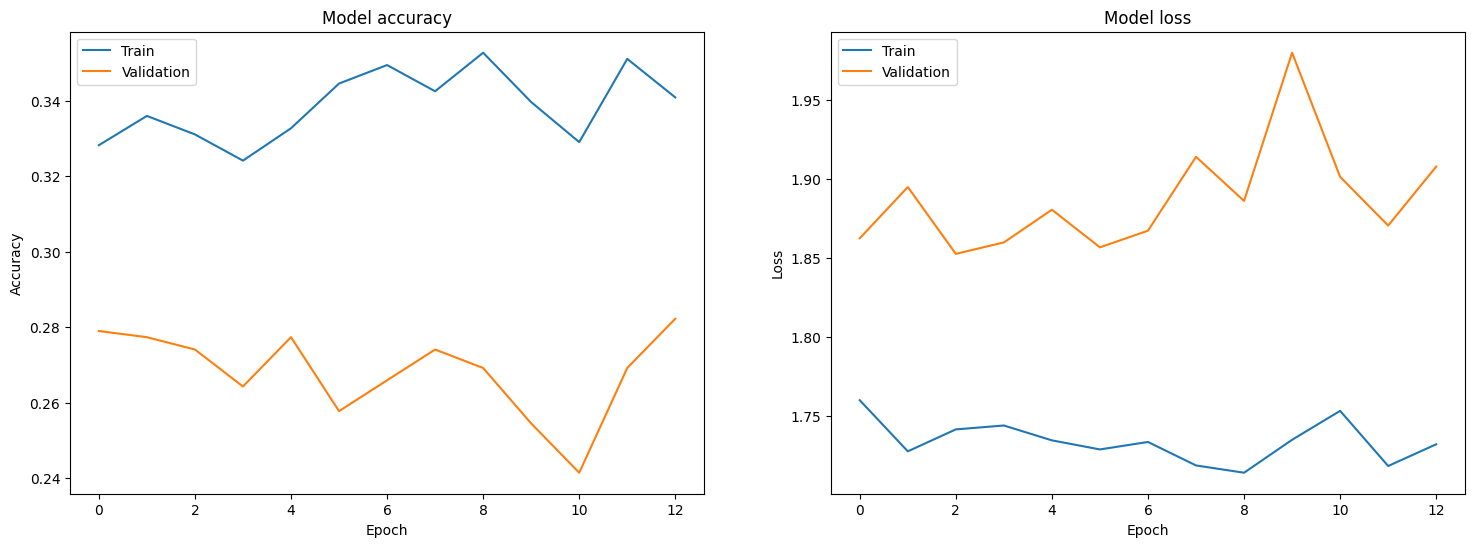

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Increase model complexity

This model also starts with a convolutional layer similar to Model 1.
It includes an additional activation layer (Activation('relu')) after the first convolutional layer, which introduces non-linearity to the model.
There is another convolutional layer with 32 filters and a kernel size of (3, 3), followed by another activation layer.
The second convolutional layer uses 'same' padding, which preserves the spatial dimensions of the input.
Finally, a max-pooling layer with a pool size of (2, 2) and strides of (2, 2) is added. This layer downsamples the feature maps, reducing their spatial dimensions.
In summary, Model 2 includes additional layers (activation layer, second convolutional layer, max-pooling layer) compared to Model 1. These additional layers can potentially enhance the model's representational power and capture more complex patterns in the input data. 

In [ ]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model2.add(Activation('relu'))
model2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model2.add(Flatten())

#dense 1
model2.add(Dense(units=128))
model2.add(Activation('relu'))

#output layer
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 activation_2 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_3 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16928)             0         
                                                      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history_2 = model2.fit_generator(data_generator.flow(train_X, train_y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es],
                                validation_data=(val_X, val_y))

<ipython-input-100-ec68132d72b5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model2.fit_generator(data_generator.flow(train_X, train_y, batch_size),


Epoch 1/50
76/76 - 13s - loss: 1.9618 - accuracy: 0.1743 - val_loss: 1.9559 - val_accuracy: 0.1615 - 13s/epoch - 164ms/step
Epoch 2/50
76/76 - 10s - loss: 1.8939 - accuracy: 0.2241 - val_loss: 1.8826 - val_accuracy: 0.2316 - 10s/epoch - 129ms/step
Epoch 3/50
76/76 - 11s - loss: 1.8107 - accuracy: 0.2849 - val_loss: 1.8269 - val_accuracy: 0.2953 - 11s/epoch - 139ms/step
Epoch 4/50
76/76 - 11s - loss: 1.7572 - accuracy: 0.3118 - val_loss: 1.7856 - val_accuracy: 0.2806 - 11s/epoch - 138ms/step
Epoch 5/50
76/76 - 11s - loss: 1.6905 - accuracy: 0.3527 - val_loss: 1.7372 - val_accuracy: 0.3344 - 11s/epoch - 140ms/step
Epoch 6/50
76/76 - 11s - loss: 1.6373 - accuracy: 0.3747 - val_loss: 1.7591 - val_accuracy: 0.3312 - 11s/epoch - 139ms/step
Epoch 7/50
76/76 - 11s - loss: 1.5776 - accuracy: 0.4037 - val_loss: 1.7267 - val_accuracy: 0.3475 - 11s/epoch - 145ms/step
Epoch 8/50
76/76 - 11s - loss: 1.5261 - accuracy: 0.4294 - val_loss: 1.6758 - val_accuracy: 0.3638 - 11s/epoch - 138ms/step
Epoch 9/

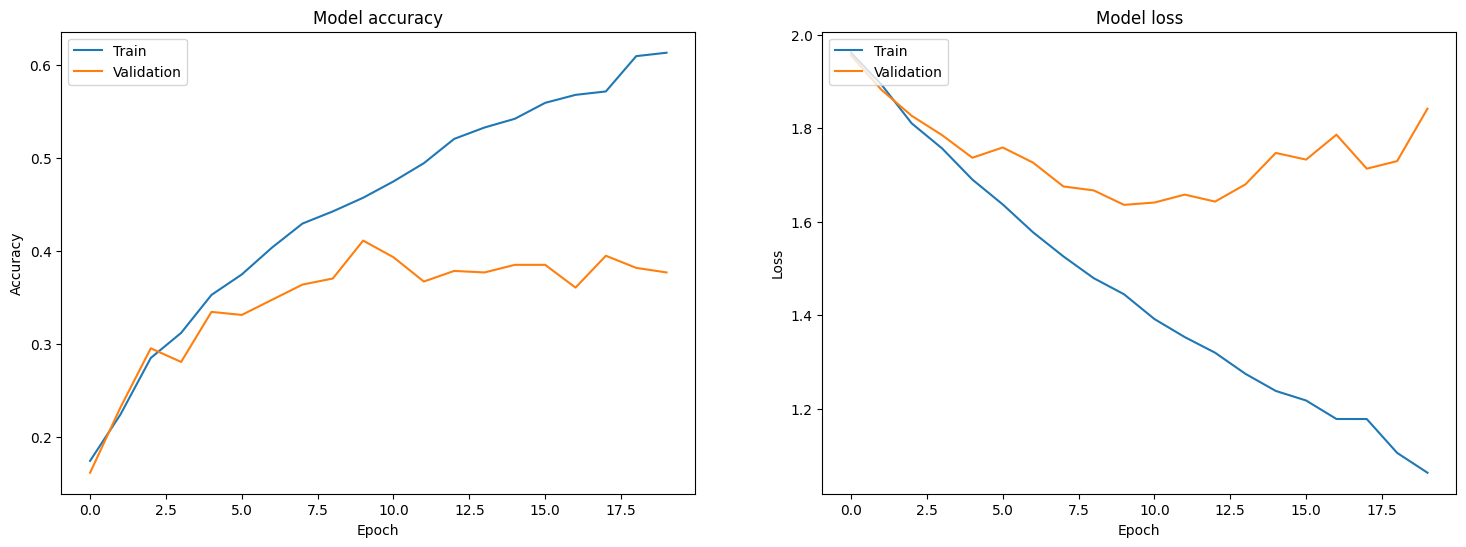

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history_2.history['accuracy'])
axes[0].plot(history_2.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history_2.history['loss'])
axes[1].plot(history_2.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Adding batch normalization

In [ ]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))
model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(Dropout(0.25))

#flatten
model3.add(Flatten())

#dense 1
model3.add(Dense(units=128))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

#output layer
model3.add(Dense(num_classes, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_14 (Activation)  (None, 46, 46, 32)        0         
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history_3 = model3.fit_generator(data_generator.flow(train_X, train_y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es],
                                validation_data=(val_X, val_y))

Epoch 1/50


<ipython-input-106-b4e534b9ca97>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_3 = model3.fit_generator(data_generator.flow(train_X, train_y, batch_size),


76/76 - 17s - loss: 2.3088 - accuracy: 0.1943 - val_loss: 2.0515 - val_accuracy: 0.2007 - 17s/epoch - 216ms/step
Epoch 2/50
76/76 - 15s - loss: 2.0153 - accuracy: 0.2596 - val_loss: 2.0872 - val_accuracy: 0.1305 - 15s/epoch - 199ms/step
Epoch 3/50
76/76 - 15s - loss: 1.9246 - accuracy: 0.2849 - val_loss: 2.0100 - val_accuracy: 0.1582 - 15s/epoch - 199ms/step
Epoch 4/50
76/76 - 15s - loss: 1.8074 - accuracy: 0.3273 - val_loss: 1.9502 - val_accuracy: 0.2480 - 15s/epoch - 202ms/step
Epoch 5/50
76/76 - 14s - loss: 1.6930 - accuracy: 0.3755 - val_loss: 1.9587 - val_accuracy: 0.2692 - 14s/epoch - 189ms/step
Epoch 6/50
76/76 - 16s - loss: 1.6550 - accuracy: 0.3857 - val_loss: 2.0829 - val_accuracy: 0.1713 - 16s/epoch - 211ms/step
Epoch 7/50
76/76 - 14s - loss: 1.6020 - accuracy: 0.3886 - val_loss: 1.8922 - val_accuracy: 0.2496 - 14s/epoch - 188ms/step
Epoch 8/50
76/76 - 14s - loss: 1.5650 - accuracy: 0.4065 - val_loss: 1.7334 - val_accuracy: 0.3116 - 14s/epoch - 189ms/step
Epoch 9/50
76/76 - 

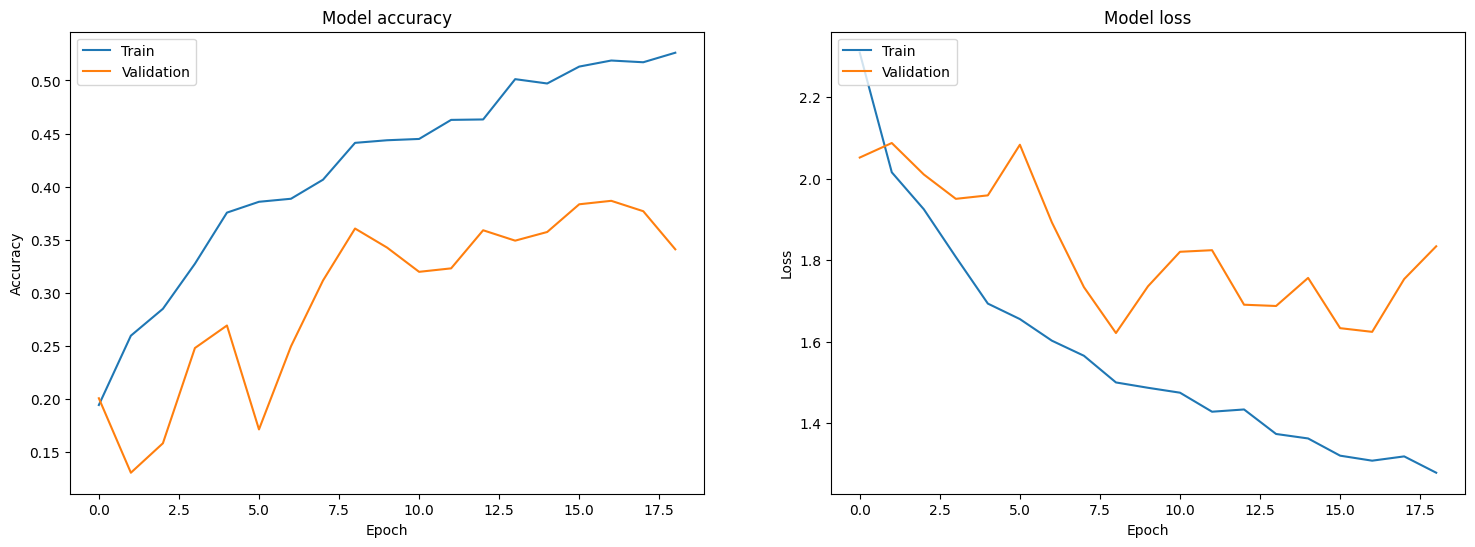

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history_3.history['accuracy'])
axes[0].plot(history_3.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history_3.history['loss'])
axes[1].plot(history_3.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model4 = Sequential()
model4.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model4.add(Dropout(0.25))

#module 2
model4.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model4.add(Dropout(0.25))

#flatten
model4.add(Flatten())

#dense 1
model4.add(Dense(units=128))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.5))

#dense 2
model4.add(Dense(units=64))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.5))

#output layer
model4.add(Dense(num_classes, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 activation_17 (Activation)  (None, 46, 46, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 46, 46, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_7 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_18 (Activation)  (None, 46, 46, 64)        0         
                                                      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history_4 = model4.fit_generator(data_generator.flow(train_X, train_y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es],
                                validation_data=(val_X, val_y))

Epoch 1/50


<ipython-input-109-be04f068b8ac>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_4 = model4.fit_generator(data_generator.flow(train_X, train_y, batch_size),


76/76 - 40s - loss: 2.4227 - accuracy: 0.1580 - val_loss: 1.9995 - val_accuracy: 0.1321 - 40s/epoch - 519ms/step
Epoch 2/50
76/76 - 37s - loss: 2.2322 - accuracy: 0.1796 - val_loss: 2.0721 - val_accuracy: 0.1321 - 37s/epoch - 488ms/step
Epoch 3/50
76/76 - 39s - loss: 2.1521 - accuracy: 0.1792 - val_loss: 2.0147 - val_accuracy: 0.1338 - 39s/epoch - 506ms/step
Epoch 4/50
76/76 - 38s - loss: 2.0687 - accuracy: 0.1947 - val_loss: 2.0202 - val_accuracy: 0.1419 - 38s/epoch - 502ms/step
Epoch 5/50
76/76 - 39s - loss: 2.0035 - accuracy: 0.1894 - val_loss: 1.9828 - val_accuracy: 0.1794 - 39s/epoch - 507ms/step
Epoch 6/50
76/76 - 37s - loss: 1.9774 - accuracy: 0.1984 - val_loss: 2.0242 - val_accuracy: 0.1648 - 37s/epoch - 488ms/step
Epoch 7/50
76/76 - 38s - loss: 1.9588 - accuracy: 0.2135 - val_loss: 1.9736 - val_accuracy: 0.1892 - 38s/epoch - 493ms/step
Epoch 8/50
76/76 - 38s - loss: 1.9599 - accuracy: 0.2065 - val_loss: 1.9435 - val_accuracy: 0.1892 - 38s/epoch - 501ms/step
Epoch 9/50
76/76 - 

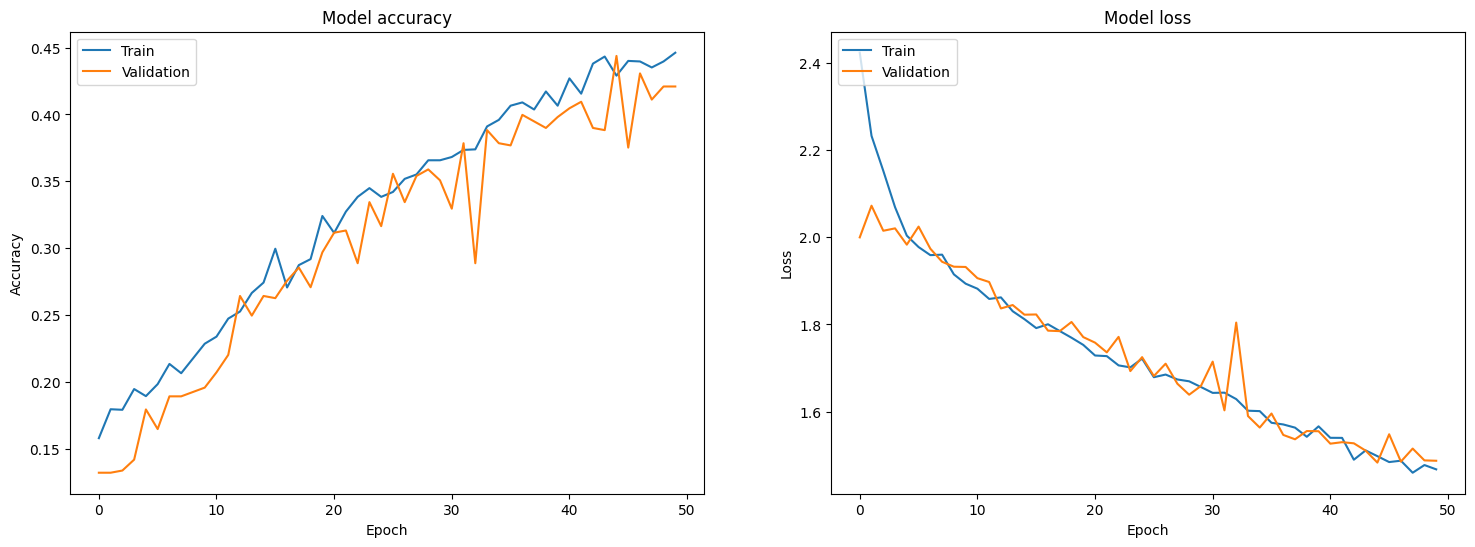

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history_4.history['accuracy'])
axes[0].plot(history_4.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history_4.history['loss'])
axes[1].plot(history_4.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model5 = Sequential()
model5.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.25))
model5.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model5.add(Dropout(0.25))

#module 2
model5.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.25))
model5.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model5.add(Dropout(0.25))

#module 3
model5.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.25))
model5.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model5.add(Dropout(0.25))

#flatten
model5.add(Flatten())

#dense 1
model5.add(Dense(units=128,kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.5))

#dense 2
model5.add(Dense(units=64,kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.5))

#dense 3
model5.add(Dense(units=32,kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.5))

#output layer
model5.add(Dense(num_classes, activation='softmax'))

model5.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       1280      
                                                                 
 batch_normalization_9 (Batc  (None, 46, 46, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 46, 46, 128)       0         
                                                                 
 dropout_9 (Dropout)         (None, 46, 46, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 128)       147584    
                                                                 
 batch_normalization_10 (Bat  (None, 46, 46, 128)      512       
 chNormalization)                                     

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history_5 = model5.fit_generator(data_generator.flow(train_X, train_y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es],
                                validation_data=(val_X, val_y))

<ipython-input-59-b55436b118f9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_5 = model5.fit_generator(data_generator.flow(train_X, train_y, batch_size),


Epoch 1/50
76/76 - 197s - loss: 5.6800 - accuracy: 0.1518 - val_loss: 5.0244 - val_accuracy: 0.1517 - 197s/epoch - 3s/step
Epoch 2/50
76/76 - 201s - loss: 5.0505 - accuracy: 0.1567 - val_loss: 4.5580 - val_accuracy: 0.1517 - 201s/epoch - 3s/step
Epoch 3/50
76/76 - 201s - loss: 4.4760 - accuracy: 0.1445 - val_loss: 4.1013 - val_accuracy: 0.1305 - 201s/epoch - 3s/step
Epoch 4/50
76/76 - 201s - loss: 3.9939 - accuracy: 0.1518 - val_loss: 3.6962 - val_accuracy: 0.1321 - 201s/epoch - 3s/step
Epoch 5/50
76/76 - 200s - loss: 3.5698 - accuracy: 0.1518 - val_loss: 3.3443 - val_accuracy: 0.1321 - 200s/epoch - 3s/step
Epoch 6/50
76/76 - 201s - loss: 3.2402 - accuracy: 0.1514 - val_loss: 3.0549 - val_accuracy: 0.1354 - 201s/epoch - 3s/step
Epoch 7/50
76/76 - 202s - loss: 2.9689 - accuracy: 0.1498 - val_loss: 2.8210 - val_accuracy: 0.1354 - 202s/epoch - 3s/step
Epoch 8/50
76/76 - 191s - loss: 2.7432 - accuracy: 0.1649 - val_loss: 2.6364 - val_accuracy: 0.1354 - 191s/epoch - 2s/step
Epoch 9/50
76/76

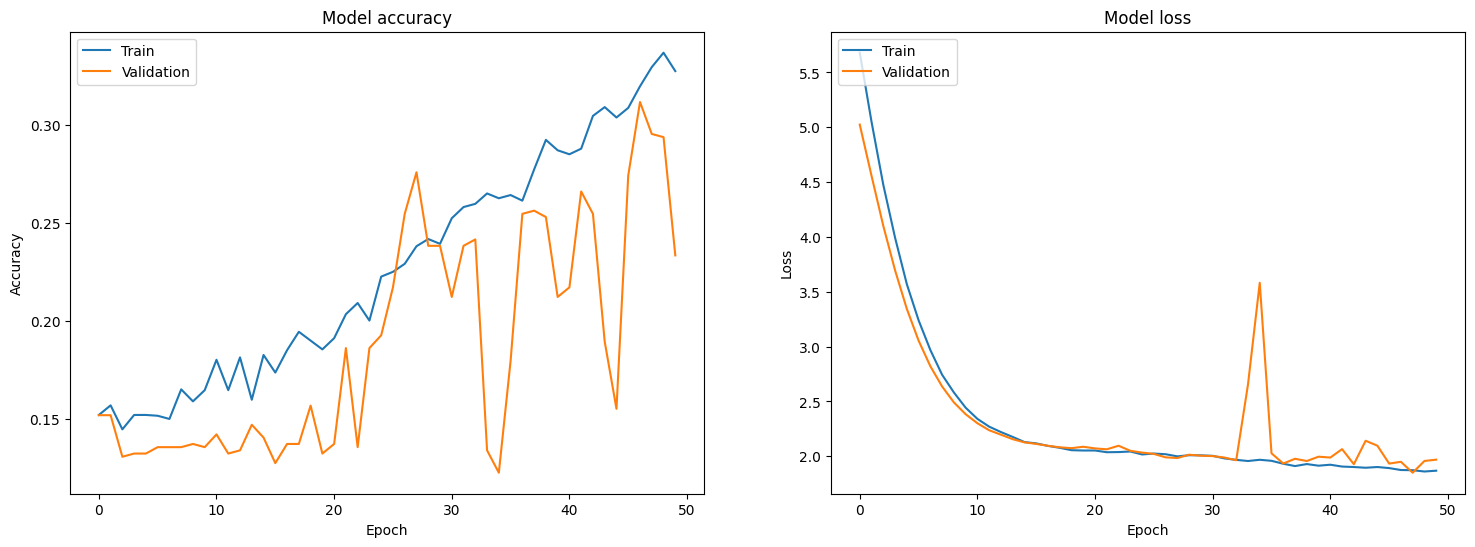

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history_5.history['accuracy'])
axes[0].plot(history_5.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history_5.history['loss'])
axes[1].plot(history_5.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#batch_size = 32
#num_epochs = 200

#es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

In [ ]:
model6 = Sequential()
model6.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.25))
model6.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model6.add(Dropout(0.25))

#module 2
model6.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.25))
model6.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model6.add(Dropout(0.25))

#flatten
model6.add(Flatten())

#dense 1
model6.add(Dense(units=128,kernel_regularizer=regularizers.l2(0.01)))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.5))

#dense 2
model6.add(Dense(units=64, kernel_regularizer=regularizers.l2(0.01)))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.5))

#output layer
model6.add(Dense(num_classes, activation='softmax'))

model6.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model6.summary()

In [ ]:
history_6 = model6.fit_generator(data_generator.flow(train_X, train_y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es],
                                validation_data=(val_X, val_y))

Epoch 1/200


<ipython-input-69-6c630f33bd2e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_6 = model6.fit_generator(data_generator.flow(train_X, train_y, batch_size),


76/76 - 68s - loss: 5.6319 - accuracy: 0.1543 - val_loss: 5.0978 - val_accuracy: 0.1517 - 68s/epoch - 888ms/step
Epoch 2/200
76/76 - 70s - loss: 4.9332 - accuracy: 0.1776 - val_loss: 4.4450 - val_accuracy: 0.1648 - 70s/epoch - 920ms/step
Epoch 3/200
76/76 - 68s - loss: 4.2768 - accuracy: 0.1624 - val_loss: 3.8384 - val_accuracy: 0.1664 - 68s/epoch - 885ms/step
Epoch 4/200
76/76 - 69s - loss: 3.6902 - accuracy: 0.2024 - val_loss: 3.3920 - val_accuracy: 0.1664 - 69s/epoch - 903ms/step
Epoch 5/200
76/76 - 68s - loss: 3.3122 - accuracy: 0.2082 - val_loss: 3.0950 - val_accuracy: 0.1599 - 68s/epoch - 885ms/step
Epoch 6/200
76/76 - 67s - loss: 3.0125 - accuracy: 0.1943 - val_loss: 2.8643 - val_accuracy: 0.1517 - 67s/epoch - 871ms/step
Epoch 7/200
76/76 - 69s - loss: 2.7671 - accuracy: 0.2082 - val_loss: 2.6951 - val_accuracy: 0.1664 - 69s/epoch - 903ms/step
Epoch 8/200
76/76 - 65s - loss: 2.6056 - accuracy: 0.2208 - val_loss: 2.5391 - val_accuracy: 0.2186 - 65s/epoch - 853ms/step
Epoch 9/200


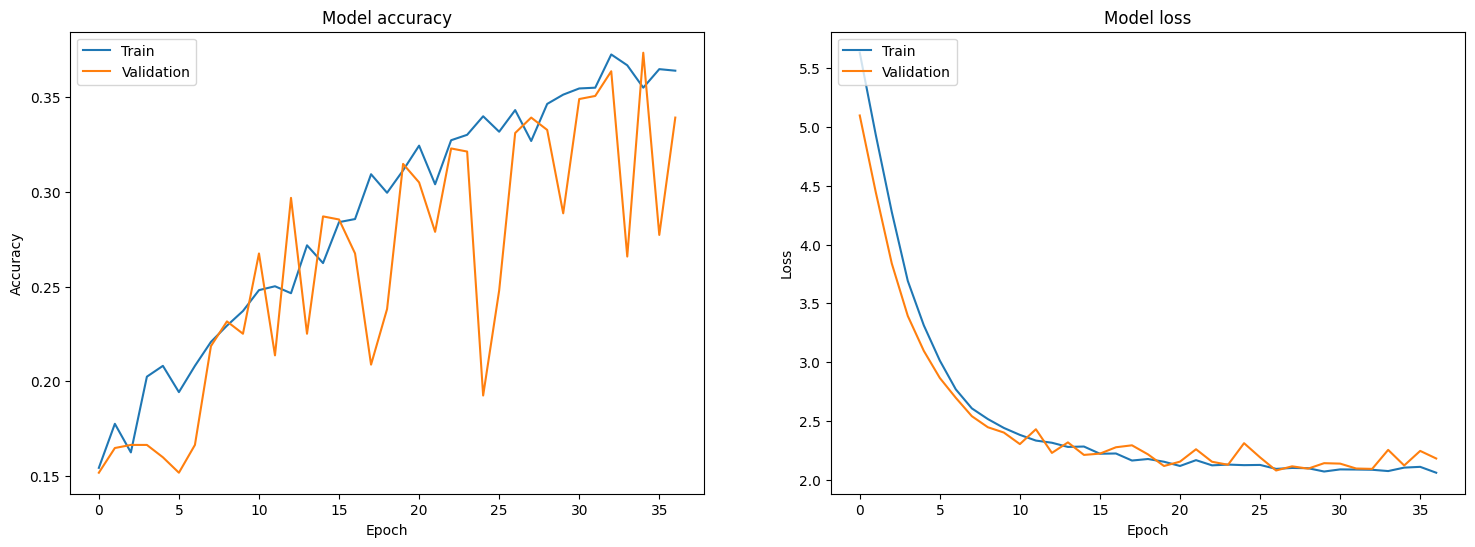

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history_6.history['accuracy'])
axes[0].plot(history_6.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history_6.history['loss'])
axes[1].plot(history_6.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
batch_size = 128
num_epochs = 200


lrr = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=75,
                                            verbose=1,
                                            factor=0.2)

es = EarlyStopping(monitor='val_loss', mode='min', patience=75, restore_best_weights=True )

In [21]:
model7 = Sequential()

model7.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(width, height, 1)))
model7.add(BatchNormalization())
model7.add(Conv2D(64, kernel_size=3, activation='relu'))
model7.add(BatchNormalization()) 
model7.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
model7.add(BatchNormalization()) 
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2)) 

model7.add(Conv2D(128, kernel_size=3, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(128, kernel_size=3, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(256, kernel_size=3, activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Flatten())
model7.add(Dense(256))
model7.add(BatchNormalization())
model7.add(Dense(128))
model7.add(BatchNormalization())
model7.add(Dense(7, activation='softmax'))

model7.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history_7 = model7.fit_generator(data_generator.flow(train_X, train_y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es, lrr],
                                validation_data=(val_X, val_y))

Epoch 1/200


<ipython-input-23-d2683ad90419>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_7 = model7.fit_generator(data_generator.flow(train_X, train_y, batch_size),


38/38 - 221s - loss: 2.2247 - accuracy: 0.1804 - val_loss: 2.1202 - val_accuracy: 0.1321 - lr: 0.0010 - 221s/epoch - 6s/step
Epoch 2/200
38/38 - 214s - loss: 1.9374 - accuracy: 0.2037 - val_loss: 2.0554 - val_accuracy: 0.1664 - lr: 0.0010 - 214s/epoch - 6s/step
Epoch 3/200
38/38 - 214s - loss: 1.9044 - accuracy: 0.2057 - val_loss: 1.9887 - val_accuracy: 0.1599 - lr: 0.0010 - 214s/epoch - 6s/step
Epoch 4/200
38/38 - 213s - loss: 1.8971 - accuracy: 0.2200 - val_loss: 2.0250 - val_accuracy: 0.1517 - lr: 0.0010 - 213s/epoch - 6s/step
Epoch 5/200
38/38 - 208s - loss: 1.8889 - accuracy: 0.2245 - val_loss: 2.0710 - val_accuracy: 0.1680 - lr: 0.0010 - 208s/epoch - 5s/step
Epoch 6/200
38/38 - 215s - loss: 1.8736 - accuracy: 0.2461 - val_loss: 2.1076 - val_accuracy: 0.1664 - lr: 0.0010 - 215s/epoch - 6s/step
Epoch 7/200
38/38 - 216s - loss: 1.8608 - accuracy: 0.2404 - val_loss: 2.0019 - val_accuracy: 0.1615 - lr: 0.0010 - 216s/epoch - 6s/step
Epoch 8/200
38/38 - 213s - loss: 1.8519 - accuracy: 0

NameError: ignored

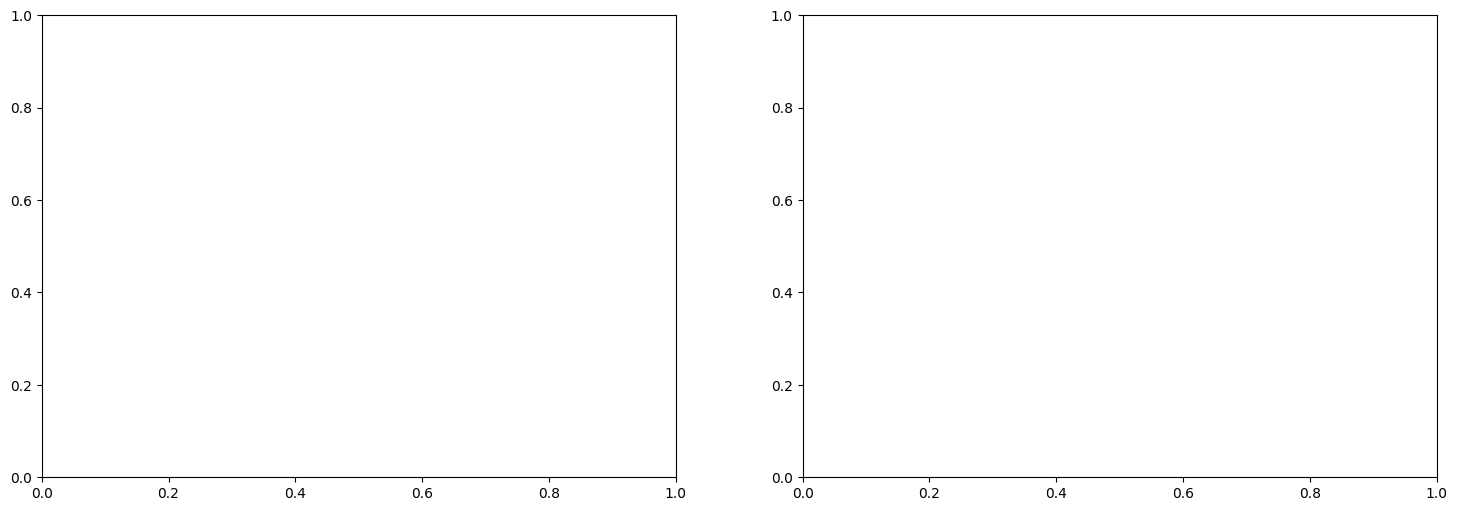

In [3]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history_7.history['accuracy'])
axes[0].plot(history_7.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history_7.history['loss'])
axes[1].plot(history_7.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()